In [1]:
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D,\
    UpSampling2D, Dropout, Activation, Flatten, Reshape, merge, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.initializers import Initializer, RandomNormal
from keras.regularizers import l2
from keras.models import Model
from PIL import Image
import scipy.misc
import matplotlib.pyplot as plt
from scipy.misc import imsave
import bcolz
import random

Using TensorFlow backend.


In [2]:
'''Note that in the paper, the output of the generative model
is tanh activation layer, which will be the input to our
discriminative model. So we need to normalize input images 
to tanh scale (-1.0 to 1.0)'''

x_train = bcolz.open('data/x_train.bc')[:]
x_train = (x_train.astype(np.float32)/255.0) * 2.0 - 1.0

In [3]:
'''Discriminator network'''
discriminator_input = Input(x_train.shape[1:])
discriminator_x = Conv2D(256, (5,5), strides=(2, 2), padding = 'same',
          kernel_regularizer = l2(0.0001))(discriminator_input)
discriminator_x = LeakyReLU(0.2)(discriminator_x)
discriminator_x = Dropout(0.5)(discriminator_x)

discriminator_x = Conv2D(512, (5,5), strides=(2, 2), padding = 'same',
          kernel_regularizer = l2(0.0001))(discriminator_x)
discriminator_x = LeakyReLU(0.2)(discriminator_x)
discriminator_x = Dropout(0.5)(discriminator_x)
discriminator_x = Flatten()(discriminator_x)

discriminator_x = Dense(256, kernel_regularizer = l2(0.0001))(discriminator_x)
discriminator_x = LeakyReLU(0.2)(discriminator_x)
discriminator_x = Dropout(0.5)(discriminator_x)

discriminator_x = Dense(1,activation='sigmoid')(discriminator_x)

discriminator_model = Model(discriminator_input,discriminator_x)
discriminator_model.compile(Adam(0.00001),loss='binary_crossentropy')

In [4]:
'''Generator network'''
generator_input = Input((100,))
generator_x = Dense(512*28*28, kernel_initializer='glorot_normal')(generator_input)
generator_x = BatchNormalization()(generator_x)
generator_x = Activation('relu')(generator_x)
generator_x = Reshape((28,28,512))(generator_x)
generator_x = UpSampling2D()(generator_x)

generator_x = Conv2D(256, (3,3), padding='same', 
                  kernel_initializer='glorot_uniform')(generator_x)
generator_x = BatchNormalization()(generator_x)
generator_x = Activation('relu')(generator_x)
generator_x = UpSampling2D()(generator_x)

generator_x = Conv2D(128, (3,3), padding='same', 
                  kernel_initializer='glorot_uniform')(generator_x)
generator_x = BatchNormalization()(generator_x)
generator_x = Activation('relu')(generator_x)

generator_x = Conv2D(64, (3,3), padding='same',
                  kernel_initializer='glorot_uniform')(generator_x)
generator_x = BatchNormalization()(generator_x)
generator_x = Activation('relu')(generator_x)

generator_x = Conv2D(3, (1,1), padding='same',
                  kernel_initializer='glorot_uniform')(generator_x)
generator_x = Activation('tanh')(generator_x)

generator_model = Model(generator_input,generator_x)
generator_model.compile(Adam(0.00001),loss='binary_crossentropy')

In [5]:
'''Freeze discriminator'''
discriminator_model.trainable = False
for layer in discriminator_model.layers:
    layer.trainable = False

'''GAN = generator + discriminator'''
gan_input = Input((100,))
gan_x = generator_model(gan_input)
gan_x = discriminator_model(gan_x)
model = Model(gan_input, gan_x)
model.compile(Adam(0.00001), loss = "binary_crossentropy")

In [6]:
'''Train discriminator for 1 epoch as a start'''
init_data = len(x_train)//2

real = np.random.permutation(x_train)[:init_data]
fake = generator_model.predict(np.random.rand(init_data,100))
x_init = np.concatenate((real,fake))

real_label = np.zeros((init_data,1))
fake_label = np.ones((init_data,1))
y_init = np.concatenate((real_label,fake_label))

In [7]:
'''Unfreeze discriminator'''
discriminator_model.trainable = True
for layer in discriminator_model.layers:
    layer.trainable = True

discriminator_model.fit(x_init,y_init,batch_size=128,epochs=1)

Epoch 1/1
9998/9998 [==============================] - 40s - loss: 0.4266    


In [8]:
discriminator_loss = []
generator_loss = []
num_data = len(x_train)

In [21]:
'''Note that our discriminator and generator models are referenced
by our GAN and we do not want the discriminator part of the GAN to be
trained when trying to minimize generator losses. To do so, we can just
do it by freezing discriminator model before training generator'''

model.optimizer = Adam(lr = 0.00001, beta_1 = 0.5, beta_2 = 0.99)
discriminator_model.optimizer = Adam(lr=0.00001, beta_1 = 0.5, beta_2 = 0.99)
generator_model.optimizer = Adam(lr=0.00001, beta_1 = 0.5, beta_2 = 0.99)

num_iterations = 50000
real_per_iter = 32
fake_per_iter = 32

real_label = np.zeros((real_per_iter,1))
fake_label = np.ones((fake_per_iter,1))
y_mini = np.concatenate((real_label,fake_label))

repeat_discriminator = 1
repeat_generator = 1

for i in range(num_iterations):
    print('Iteration #%d' % i)
    
    '''Unfreeze discriminator'''
    discriminator_model.trainable = True
    for layer in discriminator_model.layers:
        layer.trainable = True
        
    '''Training discriminator'''
    for k in range(repeat_discriminator):
        '''Create real and fake data, as well as their labels'''
        real = x_train[np.random.randint(0,high=num_data,size=real_per_iter)]
        fake = generator_model.predict(np.random.uniform(size=[fake_per_iter,100]))
        x_mini = np.concatenate((real, fake))
        discriminator_loss.append(discriminator_model.train_on_batch(x_mini,y_mini))
    
    '''Freeze discriminator'''
    discriminator_model.trainable = False
    for layer in discriminator_model.layers:
        layer.trainable = False
    
    '''Training generator'''
    for k in range(repeat_generator):
        generator_x = np.random.uniform(size=[fake_per_iter*2,100])
        generator_y = np.zeros((fake_per_iter*2,1)) #We want it to be classified as real
        generator_loss.append(model.train_on_batch(generator_x, generator_y))
    
    '''Show losses'''
    print('Discriminator loss = %.6f Generator loss = %.6f'
          % (discriminator_loss[len(discriminator_loss)-1],
             generator_loss[len(generator_loss)-1]))

Iteration #0
Discriminator loss = 0.095199 Generator loss = 0.078549
Iteration #1
Discriminator loss = 0.075824 Generator loss = 0.074475
Iteration #2
Discriminator loss = 0.087702 Generator loss = 0.091297
Iteration #3
Discriminator loss = 0.110188 Generator loss = 0.089586
Iteration #4
Discriminator loss = 0.097657 Generator loss = 0.085045
Iteration #5
Discriminator loss = 0.164238 Generator loss = 0.076626
Iteration #6
Discriminator loss = 0.107814 Generator loss = 0.079934
Iteration #7
Discriminator loss = 0.085767 Generator loss = 0.073420
Iteration #8
Discriminator loss = 0.153351 Generator loss = 0.072873
Iteration #9
Discriminator loss = 0.141834 Generator loss = 0.072342
Iteration #10
Discriminator loss = 0.131157 Generator loss = 0.071236
Iteration #11
Discriminator loss = 0.099050 Generator loss = 0.077830
Iteration #12
Discriminator loss = 0.107281 Generator loss = 0.082248
Iteration #13
Discriminator loss = 0.105854 Generator loss = 0.086819
Iteration #14
Discriminator lo

Discriminator loss = 0.081684 Generator loss = 0.072478
Iteration #118
Discriminator loss = 0.112775 Generator loss = 0.068801
Iteration #119
Discriminator loss = 0.090699 Generator loss = 0.072623
Iteration #120
Discriminator loss = 0.084610 Generator loss = 0.068763
Iteration #121
Discriminator loss = 0.084947 Generator loss = 0.070033
Iteration #122
Discriminator loss = 0.105147 Generator loss = 0.070081
Iteration #123
Discriminator loss = 0.092044 Generator loss = 0.069074
Iteration #124
Discriminator loss = 0.090639 Generator loss = 0.068513
Iteration #125
Discriminator loss = 0.091807 Generator loss = 0.068989
Iteration #126
Discriminator loss = 0.091470 Generator loss = 0.071761
Iteration #127
Discriminator loss = 0.089362 Generator loss = 0.071271
Iteration #128
Discriminator loss = 0.083633 Generator loss = 0.073589
Iteration #129
Discriminator loss = 0.077670 Generator loss = 0.072354
Iteration #130
Discriminator loss = 0.086657 Generator loss = 0.070669
Iteration #131
Discri

Discriminator loss = 0.083295 Generator loss = 0.069005
Iteration #234
Discriminator loss = 0.095698 Generator loss = 0.068726
Iteration #235
Discriminator loss = 0.084249 Generator loss = 0.068554
Iteration #236
Discriminator loss = 0.081487 Generator loss = 0.068837
Iteration #237
Discriminator loss = 0.139832 Generator loss = 0.069212
Iteration #238
Discriminator loss = 0.076352 Generator loss = 0.069881
Iteration #239
Discriminator loss = 0.206497 Generator loss = 0.071691
Iteration #240
Discriminator loss = 0.105556 Generator loss = 0.072355
Iteration #241
Discriminator loss = 0.073362 Generator loss = 0.069266
Iteration #242
Discriminator loss = 0.090605 Generator loss = 0.070715
Iteration #243
Discriminator loss = 0.079223 Generator loss = 0.069905
Iteration #244
Discriminator loss = 0.085797 Generator loss = 0.069868
Iteration #245
Discriminator loss = 0.097174 Generator loss = 0.072279
Iteration #246
Discriminator loss = 0.073442 Generator loss = 0.072313
Iteration #247
Discri

Discriminator loss = 0.068705 Generator loss = 0.066980
Iteration #350
Discriminator loss = 0.068045 Generator loss = 0.067110
Iteration #351
Discriminator loss = 0.067565 Generator loss = 0.067238
Iteration #352
Discriminator loss = 0.067336 Generator loss = 0.071210
Iteration #353
Discriminator loss = 0.200731 Generator loss = 0.066915
Iteration #354
Discriminator loss = 0.067561 Generator loss = 0.066875
Iteration #355
Discriminator loss = 0.069436 Generator loss = 0.066936
Iteration #356
Discriminator loss = 0.073246 Generator loss = 0.066888
Iteration #357
Discriminator loss = 0.081717 Generator loss = 0.067259
Iteration #358
Discriminator loss = 0.175343 Generator loss = 0.066922
Iteration #359
Discriminator loss = 0.072113 Generator loss = 0.067033
Iteration #360


KeyboardInterrupt: 

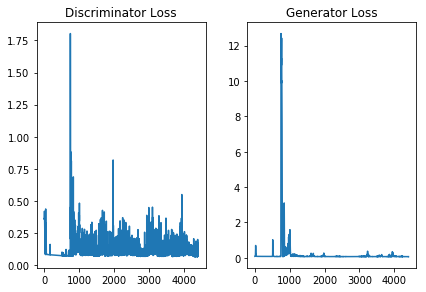

In [22]:
'''Plot discriminator and generator losses'''
figure,axis = plt.subplots(1,2)
plt.tight_layout()
axis[0].plot(discriminator_loss)
axis[0].set_title("Discriminator Loss")
axis[1].plot(generator_loss)
axis[1].set_title("Generator Loss")

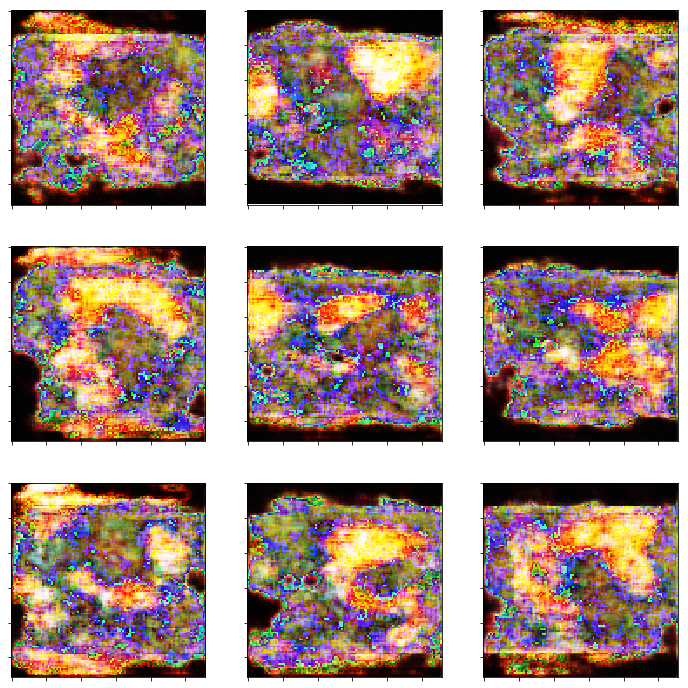

In [23]:
'''Generate images with our trained generator model'''
num_generated = 9
in_noise = np.random.rand(num_generated,100)
im = generator_model.predict(in_noise)
figure,axis = plt.subplots(3,3,figsize=(10,10))
plt.tight_layout()
for i in range(3):
    for j in range(3):
        axis[i,j].imshow(im[i*3+j])
        axis[i,j].set_yticklabels([])
        axis[i,j].set_xticklabels([])

In [ ]:
'''Save weights and models'''
discriminator_model.save_weights('discriminator_model2_weights.h5')
generator_model.save_weights('generator_model2_weights.h5')
model.save_weights('gan_model2_weights.h5')

discriminator_model.save('discriminator_model2.h5')
generator_model.save('generator_model2.h5')
model.save('gan_model2.h5')